In [1]:
from experiments.gmn_dev.optimizees import MLP
from experiments.gmn_dev.tasks import QuadraticTask, MNISTTask
from experiments.gmn_dev.config import  Config
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
config = Config()

In [3]:
train_task = QuadraticTask(
    config,
    train=True
)
test_task = QuadraticTask(
    config,
    train=False
)

train_loader = train_task.dataloader
test_loader = test_task.dataloader

/home/siddhartha/learned-optimizers/venv/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:

mlp_base = MLP(
    input_size=2, hidden_sizes=[1], output_size=1
).to(config.device)

In [5]:
optimizers = [optim.Adam(mlp_base.parameters(), lr=0.01),
             optim.SGD(mlp_base.parameters(), lr=0.01),
             optim.RMSprop(mlp_base.parameters(), lr=0.01),
            #  optim.AdamW(mlp_base.parameters(), lr=0.001),
            #  optim.Adagrad(mlp_base.parameters(), lr=0.01),
            #  optim.Adadelta(mlp_base.parameters(), lr=0.001),
            #  optim.Adamax(mlp_base.parameters(), lr=0.002),
            #  optim.NAdam(mlp_base.parameters(), lr=0.001)
            ]

loss_fn = train_task.loss_fn

In [6]:
def train(model, optimizer, train_loader, test_loader, num_epochs=15):
    print(f"\nTraining with {optimizer.__class__.__name__} optimizer")
    checkpoints = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        for i, batch in enumerate(train_loader):
            x, y = batch
            x, y = x.to(config.device), y.to(config.device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            # if i % 100 == 0:
            #     print(f"Epoch {epoch+1}/{num_epochs}, Batch {i}, Loss: {loss.item():.4f}")
        checkpoints.append(deepcopy(model).to('cpu').state_dict())
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                x, y = batch
                x, y = x.to(config.device), y.to(config.device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}")
    return checkpoints, test_losses
def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x, y = x.to(config.device), y.to(config.device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    return test_loss

In [ ]:
import uuid
# results = {optimizer.__class__.__name__: [] for optimizer in optimizers}
save_path = './experiments/gmn_dev/optimizer_trajectories'

def init_weights(model):
    weight_init_fns = [
        nn.init.xavier_uniform_,
        nn.init.xavier_normal_,
        nn.init.kaiming_uniform_,
        nn.init.kaiming_normal_,
        nn.init.orthogonal_,
        nn.init.uniform_,
        nn.init.normal_,
        ]
    
    weight_init_fn = random.choice(weight_init_fns)
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            weight_init_fn(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)
def create_optimizers(model):
    lr_range = [1e-4, 1e-1]
    
    # randomly choose a learning rate for each optimizer
    optimizers = [
        optim.Adam(model.parameters(), lr=random.uniform(lr_range[0], lr_range[1])),
        optim.SGD(model.parameters(), lr=random.uniform(lr_range[0], lr_range[1]), momentum=random.uniform(0.5, 0.9)),
        optim.RMSprop(model.parameters(), random.uniform(lr_range[0], lr_range[1]), momentum=random.uniform(0.5, 0.9)),
    ]

    return optimizers
for i in range(1000):
    mlp_base.apply(init_weights)
    original_model = deepcopy(mlp_base.state_dict())
    run_id = str(uuid.uuid4())

    optimizers = create_optimizers(mlp_base)
    run_results = {}
    for optimizer in optimizers:
        # Reset the model to its original state before training with a new optimizer
        mlp_base.load_state_dict(original_model)
        
        # Train the model with the current optimizer
        checkpoints, test_losses = train(mlp_base, optimizer, train_loader, test_loader)

        curr_result = {
            'optimizer': optimizer.__class__.__name__,
            'checkpoints': checkpoints,
            'test_losses': test_losses
        }
        
        run_results[optimizer.__class__.__name__] = curr_result
    # save run_results
    torch.save(run_results, f"{save_path}/run_{run_id}.pt")
    print(f"Run {run_id} completed and saved.")


Training with Adam optimizer
Epoch 1/15, Test Loss: 3.2720
Epoch 2/15, Test Loss: 2.2904
Epoch 3/15, Test Loss: 2.0105
Epoch 4/15, Test Loss: 1.8536
Epoch 5/15, Test Loss: 1.7249
Epoch 6/15, Test Loss: 1.6395
Epoch 7/15, Test Loss: 1.5782
Epoch 8/15, Test Loss: 1.5531
Epoch 9/15, Test Loss: 1.5297
Epoch 10/15, Test Loss: 1.5225
Epoch 11/15, Test Loss: 1.5242
Epoch 12/15, Test Loss: 1.5198
Epoch 13/15, Test Loss: 1.5192
Epoch 14/15, Test Loss: 1.5241
Epoch 15/15, Test Loss: 1.5261

Training with SGD optimizer
Epoch 1/15, Test Loss: 2.3310
Epoch 2/15, Test Loss: 2.0644
Epoch 3/15, Test Loss: 1.9654
Epoch 4/15, Test Loss: 1.8810
Epoch 5/15, Test Loss: 1.8016
Epoch 6/15, Test Loss: 1.7365
Epoch 7/15, Test Loss: 1.6811
Epoch 8/15, Test Loss: 1.6371
Epoch 9/15, Test Loss: 1.6046
Epoch 10/15, Test Loss: 1.5799
Epoch 11/15, Test Loss: 1.5613
Epoch 12/15, Test Loss: 1.5542
Epoch 13/15, Test Loss: 1.5411
Epoch 14/15, Test Loss: 1.5310
Epoch 15/15, Test Loss: 1.5306

Training with RMSprop optimi

In [ ]:
def state_dict_to_vector(state_dict):
    """Convert a PyTorch state dict to a flat vector."""
    params = []
    for key, value in state_dict.items():
        if isinstance(value, torch.Tensor):
            params.append(value.view(-1))
        else:
            raise ValueError(f"Unsupported type {type(value)} in state_dict.")
    return torch.cat(params)
def vector_to_state_dict(vector, state_dict):
    """Convert a flat vector back to a PyTorch state dict."""
    params = {}
    offset = 0
    for key, value in state_dict.items():
        if isinstance(value, torch.Tensor):
            numel = value.numel()
            params[key] = vector[offset:offset + numel].view(value.size())
            offset += numel
        else:
            raise ValueError(f"Unsupported type {type(value)} in state_dict.")
    return params



(OrderedDict([('layers.0.weight', tensor([[-0.0836,  1.2706]])),
              ('layers.0.bias', tensor([0.3111])),
              ('layers.1.weight', tensor([[1.3367]])),
              ('layers.1.bias', tensor([1.8899]))]),
 {'layers.0.weight': tensor([[-0.0836,  1.2706]]),
  'layers.0.bias': tensor([0.3111]),
  'layers.1.weight': tensor([[1.3367]]),
  'layers.1.bias': tensor([1.8899])})

In [48]:
def plot_interpolation(model, vector_a, vector_b, state_dict_a, test_loader, num_points=10, title=None):
    """
    Plots the test loss as a function of interpolation factor between two models.

    Args:
        model: The PyTorch model to evaluate.
        vector_a: The flattened parameter vector of the first model.
        vector_b: The flattened parameter vector of the second model.
        state_dict_a: The state_dict of the first model (used as a template for reconstruction).
        test_loader: DataLoader for the test dataset.
        loss_fn: Loss function to evaluate the model.
        num_points: Number of interpolation points (default: 11).
    """
    int_losses = []
    alphas = np.linspace(0, 1, num_points)
    
    for alpha in alphas:
        interpolated_vector = (1 - alpha) * vector_a + alpha * vector_b
        interpolated_state_dict = vector_to_state_dict(interpolated_vector, state_dict_a)
        model.load_state_dict(interpolated_state_dict)
        test_loss = test(model, test_loader)
        int_losses.append(test_loss)

    plt.plot(alphas, int_losses)
    plt.xlabel('Interpolation Factor (alpha)')
    plt.ylabel('Test Loss')
    if title:
        plt.title(title)
    else:
        plt.title('Interpolation Test Loss')
    plt.xticks(alphas)
    plt.grid()
    plt.show()

# plot_interpolation(mlp_base, final_adam_vector, final_sgd_vector, final_adam, test_loader, title='Adam to SGD Interpolation')
# plot_interpolation(mlp_base, final_adam_vector, final_rmsprop_vector, final_adam, test_loader, title='Adam to RMSprop Interpolation')
# plot_interpolation(mlp_base, final_sgd_vector, final_rmsprop_vector, final_sgd, test_loader, title='SGD to RMSprop Interpolation')



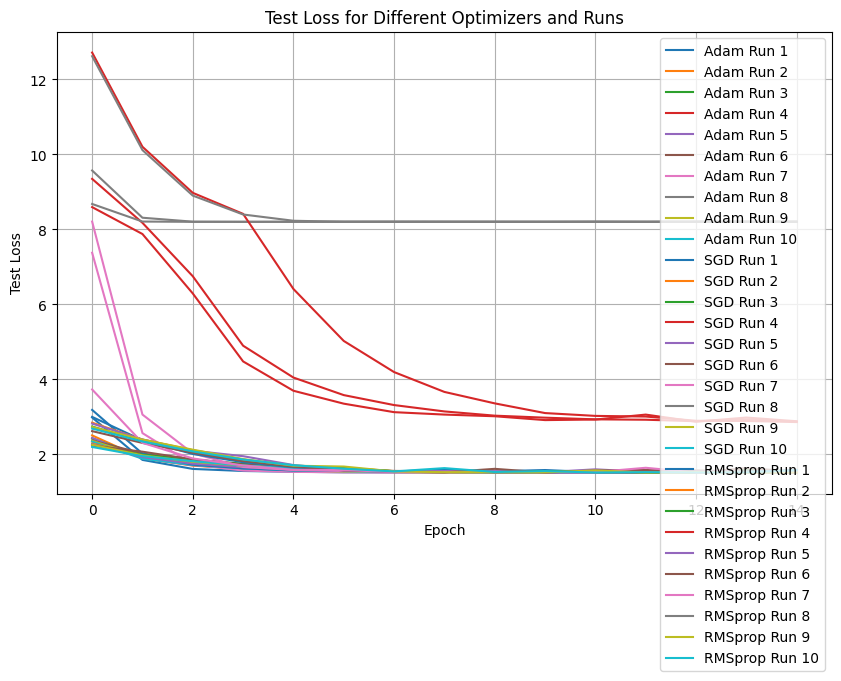

In [49]:
# plot each trajectory for each optimizer. same color for each run number



plt.figure(figsize=(10, 6))
for opt_name, runs in results.items():
    for i, run_data in enumerate(runs):
        test_losses = run_data['test_losses']
        plt.plot(test_losses, label=f'{opt_name} Run {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss for Different Optimizers and Runs')
plt.legend()
plt.grid()
plt.show()


Test Loss: 1.5209
Test Loss: 1.5202
Test Loss: 1.5197
Test Loss: 1.5194
Test Loss: 1.5194
Test Loss: 1.5194
Test Loss: 1.5197
Test Loss: 1.5202
Test Loss: 1.5208
Test Loss: 1.5217


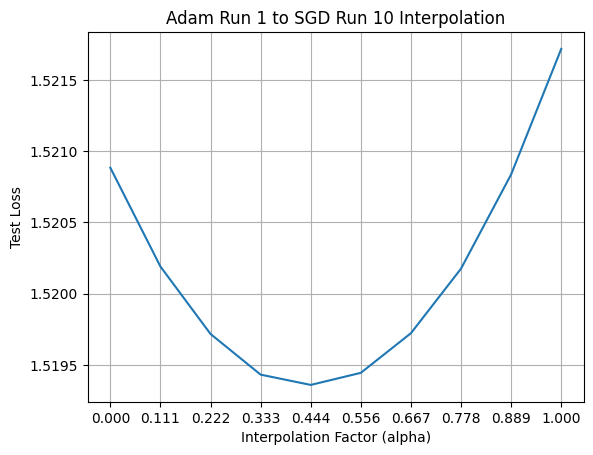

Test Loss: 1.5209
Test Loss: 1.9489
Test Loss: 2.9505
Test Loss: 4.2422
Test Loss: 5.5896
Test Loss: 6.8070
Test Loss: 7.7569
Test Loss: 8.3516
Test Loss: 8.5513
Test Loss: 8.3957


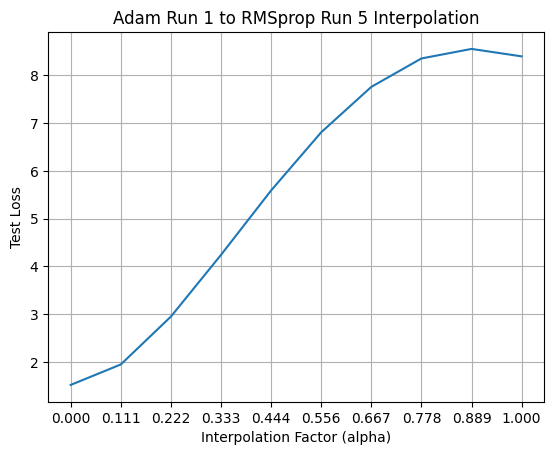

Test Loss: 1.5217
Test Loss: 1.8848
Test Loss: 2.8591
Test Loss: 4.1493
Test Loss: 5.5108
Test Loss: 6.7494
Test Loss: 7.7223
Test Loss: 8.3357
Test Loss: 8.5475
Test Loss: 8.3957


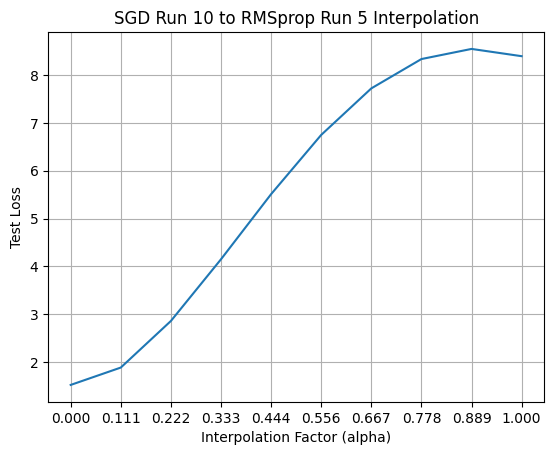

In [53]:
# take adam run 1 final, sgd run 7 final, and rmsprop run 5 final

adam_run1_final = results['Adam'][0]['checkpoints'][-1]
sgd_run10_final = results['SGD'][6]['checkpoints'][-1]
rmsprop_run5_final = results['RMSprop'][7]['checkpoints'][3]

# interpolate between adam and sgd, adam and rmsprop, sgd and rmsprop
adam_run1_final_vector = state_dict_to_vector(adam_run1_final)
sgd_run10_final_vector = state_dict_to_vector(sgd_run10_final)
rmsprop_run5_final_vector = state_dict_to_vector(rmsprop_run5_final)

plot_interpolation(mlp_base, adam_run1_final_vector, sgd_run10_final_vector, adam_run1_final, test_loader, title='Adam Run 1 to SGD Run 10 Interpolation')
plot_interpolation(mlp_base, adam_run1_final_vector, rmsprop_run5_final_vector, adam_run1_final, test_loader, title='Adam Run 1 to RMSprop Run 5 Interpolation')
plot_interpolation(mlp_base, sgd_run10_final_vector, rmsprop_run5_final_vector, sgd_run10_final, test_loader, title='SGD Run 10 to RMSprop Run 5 Interpolation')